#### Analysis & Aggregation (Guardian DRC)

The Goal here is to: turn article-level sentiment into **monthly crisis signals** for modeling against funding.

We will:
1) Load VADER and Transformer outputs
2) Build monthly aggregates (mean sentiment, neg/pos shares, volume)
3) Optionally smooth/lag features
4) Export a tidy features table ready to merge with funding data


In [1]:
# Load the libraries
import os, pandas as pd, numpy as np
from pathlib import Path
import matplotlib.pyplot as plt


In [2]:
# Load the data
# Inputs from previous notebook
VADER_IN = Path("../data/processed/sentiment_vader.parquet")
XFM_IN   = Path("../data/processed/sentiment_xfm.parquet")

# Output feature tables
OUT_MONTHLY = Path("../data/processed/features_monthly.csv")
OUT_MONTHLY_FE = Path("../data/processed/features_monthly_feather.feather")

assert VADER_IN.exists(), f"Missing {VADER_IN}"
assert XFM_IN.exists(),   f"Missing {XFM_IN}"

In [4]:
v = pd.read_parquet(VADER_IN)
x = pd.read_parquet(XFM_IN)

# parse date
for df in (v, x):
    df["pub_date"] = pd.to_datetime(df["pub_date"], errors="coerce")
    df.dropna(subset=["pub_date"], inplace=True)
    df["month"] = df["pub_date"].dt.to_period("M").astype(str)

print("VADER rows:", len(v), "Transformer rows:", len(x))
v.head(5)


VADER rows: 4733 Transformer rows: 1976


/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_59923/222605958.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["pub_date"].dt.to_period("M").astype(str)
/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_59923/222605958.py:8: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["pub_date"].dt.to_period("M").astype(str)


,pub_date,year,month,web_url,section_name,text,neg,neu,pos,compound
0,2013-08-22 16:19:22+00:00,2013,2013-08,https://www.theguardian.com/global-development...,Global development,The battle to eliminate polio has hit apparent...,0.091,0.861,0.048,-0.9902
1,2002-01-31 12:01:31+00:00,2002,2002-01,https://www.theguardian.com/theguardian/2002/j...,Global,"Harambee, or self-help, has a special meaning ...",0.046,0.822,0.133,0.9971
2,2008-10-31 12:24:37+00:00,2008,2008-10,https://www.theguardian.com/politics/2008/oct/...,Politics,October 30 session European Investment Bank Al...,0.147,0.729,0.124,-0.9908
3,2018-06-21 12:28:36+00:00,2018,2018-06,https://www.theguardian.com/global-development...,Global development,The Trump administration’s decision to withdra...,0.119,0.803,0.078,-0.9929
4,2011-11-30 10:39:11+00:00,2011,2011-11,https://www.theguardian.com/theguardian/2011/n...,News,"A big week for elections, or a week of big ele...",0.027,0.851,0.122,0.9917


#### Normalize transformer labels to polarity score

In [5]:
def label_to_polarity(label: str) -> int:
    if not isinstance(label, str):
        return 0
    lab = label.upper()
    if "NEG" in lab: return -1
    if "POS" in lab: return +1
    return 0

x["hf_polarity"] = x["hf_label"].map(label_to_polarity).fillna(0).astype(int)

# Convert to a signed score ∈ [−1, +1]
# score is confidence; signed score = polarity * score
x["hf_signed"] = x["hf_polarity"] * x["hf_score"].astype(float)

x[["hf_label","hf_score","hf_polarity","hf_signed"]].head(5)


,hf_label,hf_score,hf_polarity,hf_signed
0,neutral,0.666770,0,0.000000
1,neutral,0.502389,0,0.000000
2,negative,0.830148,-1,-0.830148
3,neutral,0.899612,0,0.000000
4,neutral,0.667854,0,0.000000


#### Define aggregation helper functions

In [8]:
def agg_vader_monthly(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    # flags on the specific column we aggregate
    d["vader_neg_flag"] = d["compound"] < -0.3
    d["vader_pos_flag"] = d["compound"] >  0.3

    out = (d.groupby("month")
             .agg(
                 n_articles=("web_url", "nunique"),
                 vader_mean=("compound", "mean"),
                 vader_med=("compound", "median"),
                 vader_std=("compound", "std"),
                 vader_neg_share=("vader_neg_flag", "mean"),
                 vader_pos_share=("vader_pos_flag", "mean"),
             )
             .reset_index())
    return out


def agg_xfm_monthly(df: pd.DataFrame) -> pd.DataFrame:
    d = df.copy()
    # ensure polarity/signed exist (if not already added earlier)
    if "hf_polarity" not in d.columns:
        d["hf_polarity"] = d["hf_label"].str.upper().map(
            lambda s: -1 if "NEG" in s else (1 if "POS" in s else 0)
        ).fillna(0).astype(int)
    if "hf_signed" not in d.columns:
        d["hf_signed"] = d["hf_polarity"] * d["hf_score"].astype(float)

    d["xfm_neg_flag"] = d["hf_polarity"] == -1
    d["xfm_pos_flag"] = d["hf_polarity"] ==  1

    out = (d.groupby("month")
             .agg(
                 xfm_n_articles=("web_url", "nunique"),
                 xfm_signed_mean=("hf_signed", "mean"),
                 xfm_neg_share=("xfm_neg_flag", "mean"),
                 xfm_pos_share=("xfm_pos_flag", "mean"),
             )
             .reset_index())
    return out


#### Compute Monthly averages and merge

In [9]:
v_month = agg_vader_monthly(v)
x_month = agg_xfm_monthly(x)

# Merge on month; keep outer join to see any gaps by method
features = pd.merge(v_month, x_month, on="month", how="outer").sort_values("month").reset_index(drop=True)

# Fill minor NaNs (e.g., months present in one set but not the other)
for col in features.columns:
    if col == "month": continue
    features[col] = features[col].astype(float)

features.head(10)

,month,n_articles,vader_mean,vader_med,vader_std,vader_neg_share,vader_pos_share,xfm_n_articles,xfm_signed_mean,xfm_neg_share,xfm_pos_share
0,2000-01,10.0,-0.197550,-0.96485,1.011592,0.600000,0.400000,3.0,0.297448,0.000000,0.333333
1,2000-02,10.0,-0.445730,-0.99025,0.814805,0.700000,0.200000,7.0,-0.218992,0.285714,0.000000
2,2000-03,11.0,0.107000,0.94320,1.004162,0.454545,0.545455,9.0,-0.193262,0.333333,0.000000
3,2000-04,18.0,-0.070661,-0.45975,0.938392,0.555556,0.444444,10.0,-0.178062,0.300000,0.000000
4,2000-05,6.0,0.677867,0.98380,0.744045,0.166667,0.833333,1.0,0.831111,0.000000,1.000000
5,2000-06,11.0,-0.403909,-0.91390,0.876027,0.727273,0.272727,6.0,0.008083,0.166667,0.166667
6,2000-07,6.0,0.563067,0.97960,0.798704,0.166667,0.833333,4.0,0.000000,0.000000,0.000000
7,2000-08,10.0,-0.386130,-0.96540,0.953074,0.700000,0.300000,5.0,-0.104358,0.200000,0.000000
8,2000-09,9.0,0.251767,0.97720,0.929689,0.333333,0.555556,4.0,0.000000,0.000000,0.000000
9,2000-10,22.0,-0.529245,-0.88940,0.746863,0.772727,0.181818,10.0,-0.312589,0.500000,0.000000


#### Smoothing rolling means
Useful when modeling delayed funding response

In [10]:
def add_roll_and_lag(df: pd.DataFrame, cols, window=3, lags=(1,)):
    out = df.copy()
    # ensure month is sortable as datetime
    out["_month_dt"] = pd.to_datetime(out["month"])
    out = out.sort_values("_month_dt")

    for c in cols:
        # rolling mean
        out[f"{c}_roll{window}"] = out[c].rolling(window=window, min_periods=1).mean()
        # lags
        for L in lags:
            out[f"{c}_lag{L}"] = out[c].shift(L)
    return out.drop(columns=["_month_dt"])

metric_cols = [
    "n_articles", "vader_mean", "vader_neg_share", "vader_pos_share",
    "xfm_n_articles", "xfm_signed_mean", "xfm_neg_share", "xfm_pos_share"
]

features = add_roll_and_lag(features, metric_cols, window=3, lags=(1,2,3))
features.tail(5)


,month,n_articles,vader_mean,vader_med,vader_std,vader_neg_share,vader_pos_share,xfm_n_articles,xfm_signed_mean,xfm_neg_share,...,xfm_signed_mean_lag2,xfm_signed_mean_lag3,xfm_neg_share_roll3,xfm_neg_share_lag1,xfm_neg_share_lag2,xfm_neg_share_lag3,xfm_pos_share_roll3,xfm_pos_share_lag1,xfm_pos_share_lag2,xfm_pos_share_lag3
305,2025-06,15.0,0.193420,0.92100,0.973387,0.400000,0.600000,6.0,-0.126844,0.333333,...,-0.217109,0.005694,0.365079,0.333333,0.428571,0.250000,0.158730,0.166667,0.142857,0.250000
306,2025-07,13.0,0.367915,0.94310,0.944459,0.307692,0.692308,4.0,0.060370,0.250000,...,-0.096880,-0.217109,0.305556,0.333333,0.333333,0.428571,0.194444,0.166667,0.166667,0.142857
307,2025-08,15.0,0.583720,0.98370,0.808298,0.200000,0.800000,6.0,0.000000,0.000000,...,-0.126844,-0.096880,0.194444,0.250000,0.333333,0.333333,0.138889,0.250000,0.166667,0.166667
308,2025-09,13.0,0.090292,0.98610,1.015360,0.461538,0.538462,7.0,-0.101958,0.285714,...,0.060370,-0.126844,0.178571,0.000000,0.250000,0.333333,0.130952,0.000000,0.250000,0.166667
309,2025-10,12.0,0.586175,0.98685,0.761962,0.166667,0.750000,4.0,0.142110,0.000000,...,0.000000,0.060370,0.095238,0.285714,0.000000,0.250000,0.130952,0.142857,0.000000,0.250000


#### Visual plots for quick check

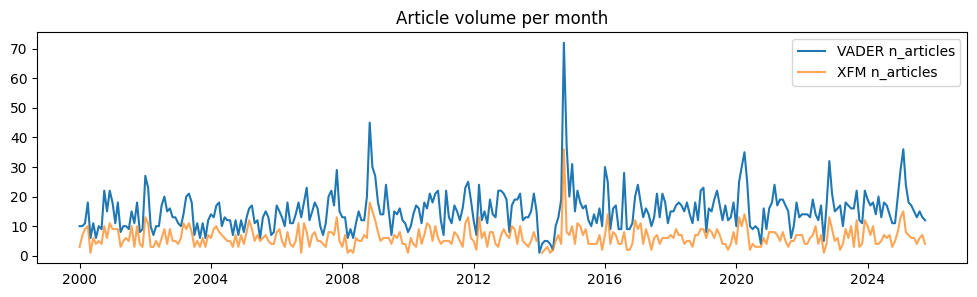

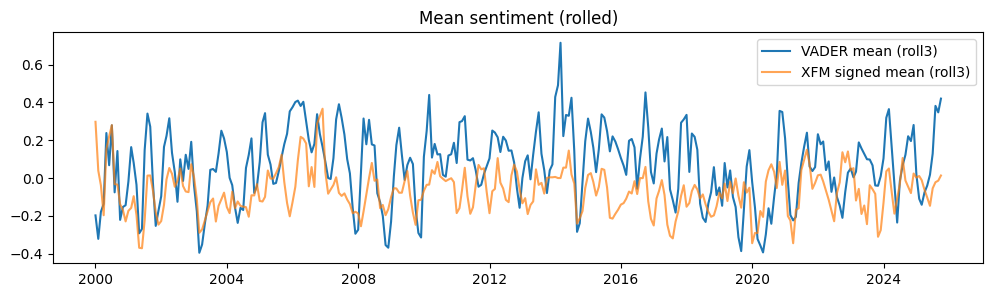

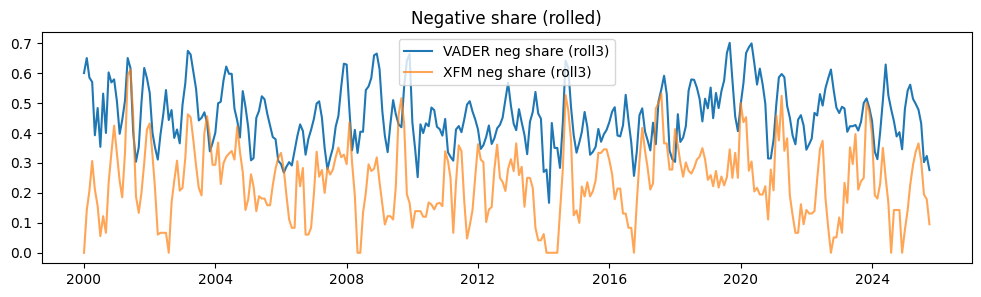

In [11]:
plt.figure(figsize=(12,3))
plt.plot(pd.to_datetime(features["month"]), features["n_articles"], label="VADER n_articles")
plt.plot(pd.to_datetime(features["month"]), features["xfm_n_articles"], label="XFM n_articles", alpha=0.7)
plt.title("Article volume per month")
plt.legend()
plt.show()

plt.figure(figsize=(12,3))
plt.plot(pd.to_datetime(features["month"]), features["vader_mean_roll3"], label="VADER mean (roll3)")
plt.plot(pd.to_datetime(features["month"]), features["xfm_signed_mean_roll3"], label="XFM signed mean (roll3)", alpha=0.7)
plt.title("Mean sentiment (rolled)")
plt.legend()
plt.show()

plt.figure(figsize=(12,3))
plt.plot(pd.to_datetime(features["month"]), features["vader_neg_share_roll3"], label="VADER neg share (roll3)")
plt.plot(pd.to_datetime(features["month"]), features["xfm_neg_share_roll3"], label="XFM neg share (roll3)", alpha=0.7)
plt.title("Negative share (rolled)")
plt.legend()
plt.show()

#### Export table
To be merged with the funding data

In [12]:
features.to_csv(OUT_MONTHLY, index=False)
try:
    features.to_feather(OUT_MONTHLY_FE)
except Exception as e:
    print("Feather export skipped:", e)

print("Saved features:")
print(" -", OUT_MONTHLY)
print(" -", OUT_MONTHLY_FE if OUT_MONTHLY_FE.exists() else "(feather not written)")
features.tail(3)

Saved features:
 - ../data/processed/features_monthly.csv
 - ../data/processed/features_monthly_feather.feather


,month,n_articles,vader_mean,vader_med,vader_std,vader_neg_share,vader_pos_share,xfm_n_articles,xfm_signed_mean,xfm_neg_share,...,xfm_signed_mean_lag2,xfm_signed_mean_lag3,xfm_neg_share_roll3,xfm_neg_share_lag1,xfm_neg_share_lag2,xfm_neg_share_lag3,xfm_pos_share_roll3,xfm_pos_share_lag1,xfm_pos_share_lag2,xfm_pos_share_lag3
307,2025-08,15.0,0.583720,0.98370,0.808298,0.200000,0.800000,6.0,0.000000,0.000000,...,-0.126844,-0.096880,0.194444,0.250000,0.333333,0.333333,0.138889,0.250000,0.166667,0.166667
308,2025-09,13.0,0.090292,0.98610,1.015360,0.461538,0.538462,7.0,-0.101958,0.285714,...,0.060370,-0.126844,0.178571,0.000000,0.250000,0.333333,0.130952,0.000000,0.250000,0.166667
309,2025-10,12.0,0.586175,0.98685,0.761962,0.166667,0.750000,4.0,0.142110,0.000000,...,0.000000,0.060370,0.095238,0.285714,0.000000,0.250000,0.130952,0.142857,0.000000,0.250000


#### Section level breakdown

In [13]:
def section_month_agg(df, id_cols, score_cols, section_col="section_name"):
    d = df.copy()
    d["month"] = pd.to_datetime(d["pub_date"]).dt.to_period("M").astype(str)
    g = d.groupby(["month", section_col])
    out = g.agg(**{
        **{f"n_{c}": (c, "count") for c in id_cols},
        **{f"mean_{s}": (s, "mean") for s in score_cols}
    }).reset_index()
    return out

sec_v = section_month_agg(v, id_cols=["web_url"], score_cols=["compound"], section_col="section_name")
sec_x = x.copy()
sec_x["month"] = pd.to_datetime(sec_x["pub_date"]).dt.to_period("M").astype(str)
sec_x["neg"] = (sec_x["hf_polarity"] == -1).astype(int)
sec_x["pos"] = (sec_x["hf_polarity"] ==  1).astype(int)
sec_x["signed"] = sec_x["hf_signed"]

sec_x_agg = sec_x.groupby(["month","section_name"]).agg(
    n_articles=("web_url","nunique"),
    neg_share=("neg","mean"),
    pos_share=("pos","mean"),
    signed_mean=("signed","mean")
).reset_index()

sec_v.head(3), sec_x_agg.head(3)

/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_59923/721704153.py:3: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  d["month"] = pd.to_datetime(d["pub_date"]).dt.to_period("M").astype(str)
/var/folders/z3/1tsrg0zj0qv7w9qv90t199n40000gn/T/ipykernel_59923/721704153.py:13: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  sec_x["month"] = pd.to_datetime(sec_x["pub_date"]).dt.to_period("M").astype(str)


(     month section_name  n_web_url  mean_compound
 0  2000-01        Books          1       -0.98070
 1  2000-01     Football          2        0.99505
 2  2000-01       Global          1        0.98620,
      month section_name  n_articles  neg_share  pos_share  signed_mean
 0  2000-01        Books           1        0.0        1.0     0.892343
 1  2000-01     Football           1        0.0        0.0     0.000000
 2  2000-01   World news           1        0.0        0.0     0.000000)